In [1]:
import xarray as xr

from weather_class import WeatherData
from torch.utils.data import DataLoader

# base = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherForecasting/data/era5_training.nc')
base = xr.open_dataset('/teamspace/studios/this_studio/WeatherForecasting/data/era5_testing.nc')
base.load()

<xarray.Dataset> Size: 139MB
Dimensions:         (time: 1464, pressure_level: 1, latitude: 49, longitude: 69)
Coordinates:
  * time            (time) datetime64[ns] 12kB 2020-01-01 ... 2020-12-31T18:0...
  * pressure_level  (pressure_level) float64 8B 850.0
  * latitude        (latitude) float64 392B -35.0 -34.75 -34.5 ... -23.25 -23.0
  * longitude       (longitude) float64 552B 16.0 16.25 16.5 ... 32.5 32.75 33.0
Data variables:
    z               (time, pressure_level, latitude, longitude) float32 20MB ...
    r               (time, pressure_level, latitude, longitude) float32 20MB ...
    t               (time, pressure_level, latitude, longitude) float32 20MB ...
    u               (time, pressure_level, latitude, longitude) float32 20MB ...
    v               (time, pressure_level, latitude, longitude) float32 20MB ...
    w               (time, pressure_level, latitude, longitude) float32 20MB ...
    wind_speed      (time, pressure_level, latitude, longitude) float32 20MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-21T12:48 GRIB to CDM+CF via cfgrib-0.9.1...

In [2]:
window_size = 3
steps = 5
data_split = 'train'
lightning = True
only_wspd = True
batch_size = 32


train_loader = DataLoader(WeatherData(base, window_size, steps, 'train', coarsen = 2, lightning=lightning, only_wspd=only_wspd), 
                          batch_size=batch_size, shuffle=True)

val_loader = DataLoader(WeatherData(base, window_size, steps, 'val', coarsen = 2, lightning=lightning, only_wspd=only_wspd),
                        batch_size=batch_size, shuffle=False)

for i, data in enumerate(train_loader):
    x, F, M, y = data
    break

print(x.shape)
print(F.shape)
print(M.shape)
print(y.shape)

torch.Size([32, 3, 24, 32])
torch.Size([32, 2])
torch.Size([32, 24, 32])
torch.Size([32, 5, 24, 32])


In [3]:
import torch

class SimpleMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        # self.fc1 = torch.nn.Linear(input_size, hidden_size)
        # self.relu = torch.nn.ReLU()
        # self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc4 = torch.nn.Linear(64, output_size)


    def step(self, x, F, M):

        lat, lon = x.shape[-2:]
        # Flatten the X and M tensors
        x = x.view(x.size(0), -1)
        M = M.view(M.size(0), -1)

        # Concatenate the x, F, and M tensors
        # x = torch.cat((x, F, M), dim=1)
        x = torch.cat((x, F), dim=1)
        # out = self.fc1(x)
        # out = self.relu(out)
        # out = self.fc2(out)

        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = self.fc4(out)

        out = out.reshape(-1, lat, lon)
        return out
    
    def rollout(self, x, F, M, steps):
        y_hats = []

        current_X = x
        current_F = F
        current_M = M

        for i in range(steps):
            y_hat = self.step(current_X, current_F, current_M)

            y_hats.append(y_hat)

            current_X = torch.cat((current_X[:, 1:], y_hat.unsqueeze(1)), dim=1)

            hour = current_F[:, 0]
            month = current_F[:, 1]
            
            hour = (hour + 1) % 24

            current_F = torch.stack((hour, month), dim=1).float()

        return torch.stack(y_hats, dim=1)
    
    def forward(self, x, F, M, steps):
        return self.rollout(x, F, M, steps)
    
input_size = x.shape[1] * x.shape[2] * x.shape[3] + F.shape[1]# + M.shape[1] * M.shape[2]
output_size = x.shape[2] * x.shape[3]
    
model = SimpleMLP(input_size, output_size, output_size)
out = model(x, F, M, 4)
out.shape

torch.Size([32, 4, 24, 32])

In [4]:
import datetime
import torch.nn as nn

import numpy as np

def init_weights(m: nn.Module) -> None:

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  
        if m.bias is not None:
            nn.init.constant_(m.bias, 0) 

def train_multi(train_loader, val_loader, model, epochs: int = 10, save_path: str = None, patience: int = 5, lr_: float = 0.0001, 
                batch_size_: int = 128, train_steps: int = 3, load_weights: str = None) -> None:
    
    if save_path is None:
        save_path = f'{datetime.now().month}_{datetime.now().day}_{datetime.now().hour}_{datetime.now().minute}.pth'

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(betas=(0.9, 0.95), lr=lr_, params=model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f'Training on {device}')
    
    if load_weights is not None:
        model.load_state_dict(torch.load(load_weights))
    else:
        model.apply(init_weights)

    model.to(device)
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    counter = 0

    for epoch in range(epochs):

        model.train()

        epoch_loss = 0
        
        for X_batch, F_batch, M_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            F_batch = F_batch.to(device)
            M_batch = M_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()

            counter += 1

            current_input = X_batch.clone()  # Initialize predictions with the first input state
            current_F = F_batch.clone()
            current_M = M_batch.clone()

            outputs = model(current_input, current_F, current_M, train_steps)

            loss = criterion(outputs, y_batch[:, :train_steps])

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)

    

        avg_loss = epoch_loss / counter

        scheduler.step(avg_loss)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}, Best Loss: {best_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        model.eval()

        val_loss = 0

        with torch.no_grad():
            counter = 0
            for X_val, F_val, M_val, y_val in val_loader:
                X_val = X_val.to(device)
                F_val = F_val.to(device)
                M_val = M_val.to(device)
                y_val = y_val.to(device)

                counter += 1

                y_hat = model(X_val, F_val, M_val, train_steps)

                loss = criterion(y_hat, y_val[:, :train_steps])

                val_loss += loss.item() * X_val.size(0)
            
        avg_val_loss = val_loss / counter

        print(f'Validation Loss: {avg_val_loss}')

        # Checkpointing
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f'Saved best model to {save_path}')
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

    return model


model = train_multi(train_loader, val_loader, model, epochs=200, 
                            save_path='model.pth', patience=5, lr_=0.0001, 
                            batch_size_=32, train_steps=1)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training on cpu
Epoch 1/200, Loss: 8.027014843893774, Best Loss: inf, LR: 0.0001
Validation Loss: 7.141475786313866
Saved best model to model.pth
Epoch 2/200, Loss: 3.0885883246858916, Best Loss: 7.141475786313866, LR: 0.0001
Validation Loss: 5.122815204840718
Saved best model to model.pth
Epoch 3/200, Loss: 2.0955130261453716, Best Loss: 5.122815204840718, LR: 0.0001
Validation Loss: 3.258094961670312
Saved best model to model.pth
Epoch 4/200, Loss: 1.2743464023100608, Best Loss: 3.258094961670312, LR: 0.0001
Validation Loss: 1.8678059504564963
Saved best model to model.pth
Epoch 5/200, Loss: 0.7041236459644455, Best Loss: 1.8678059504564963, LR: 0.0001
Validation Loss: 0.9874163157109058
Saved best model to model.pth
Epoch 6/200, Loss: 0.3659976948842858, Best Loss: 0.9874163157109058, LR: 0.0001
Validation Loss: 0.5147816783212351
Saved best model to model.pth
Epoch 7/200, Loss: 0.2043752598181141, Best Loss: 0.5147816783212351, LR: 0.0001
Validation Loss: 0.3202062888691823
Saved b

Output shape:  torch.Size([32, 5, 24, 32])


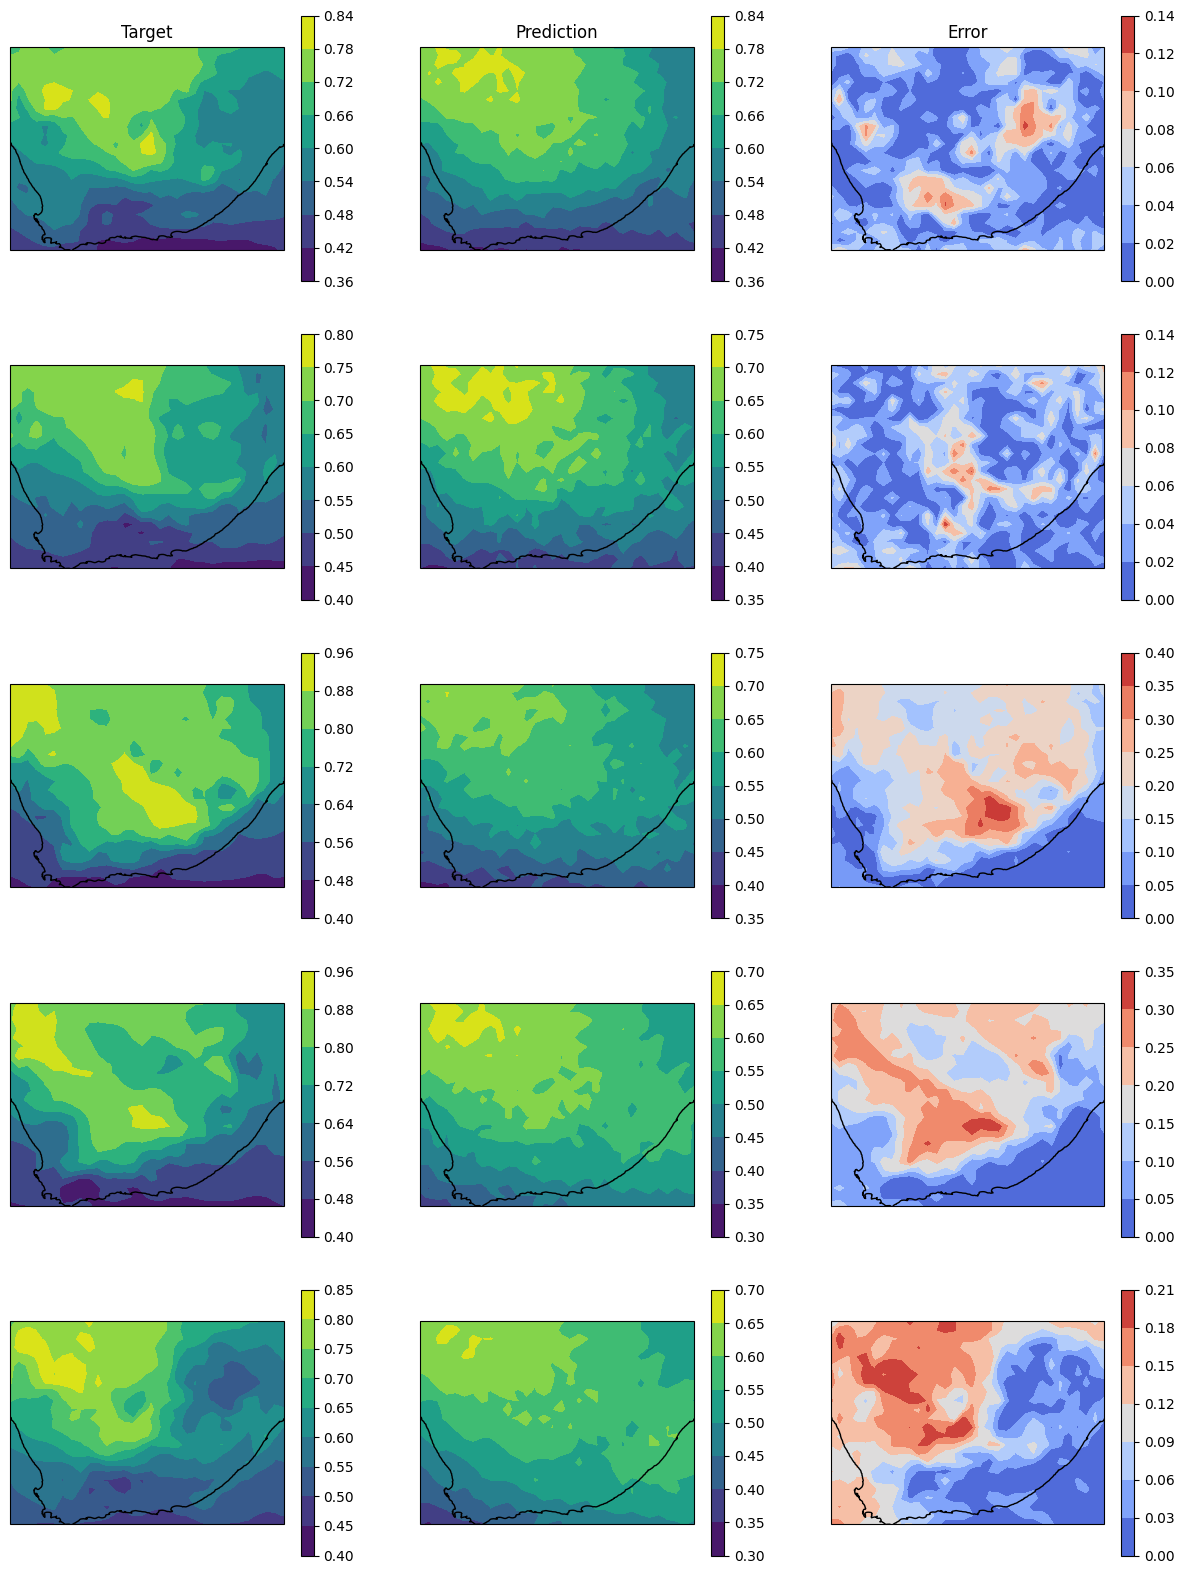

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

test_loader = DataLoader(WeatherData(base, window_size, steps, 'test', coarsen = 2, lightning=lightning, only_wspd=only_wspd),
                        batch_size=batch_size, shuffle=False)

for i, data in enumerate(test_loader):
    x, F, M, y = data
    break

y_hat = model(x, F, M, 5)
print('Output shape: ', y_hat.shape)

seed = 5

fig, axs = plt.subplots(5, 3, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axs:
    for a in ax:
        a.coastlines()

for i in range(5):
    tar = axs[i, 0].contourf(base.isel(longitude=slice(2, 66, 2)).longitude, base.isel(latitude=slice(1, 48, 2)).latitude, y[seed, i].detach().numpy())
    plt.colorbar(tar, ax=axs[i, 0])
    pred = axs[i, 1].contourf(base.isel(longitude=slice(2, 66, 2)).longitude,  base.isel(latitude=slice(1, 48, 2)).latitude, y_hat[seed, i].detach().numpy())
    plt.colorbar(pred, ax=axs[i, 1])
    error = np.abs(y[seed, i].detach().numpy() - y_hat[seed, i].detach().numpy())
    err = axs[i, 2].contourf(base.isel(longitude=slice(2, 66, 2)).longitude,  base.isel(latitude=slice(1, 48, 2)).latitude, error, cmap='coolwarm')
    plt.colorbar(err, ax=axs[i, 2])

axs[0, 0].set_title('Target')
axs[0, 1].set_title('Prediction')
axs[0, 2].set_title('Error')


plt.show()

